# High Performance Computing

## 1. Introduction

Perhaps the single most notable feature of scientific computing in the past two decades is the rise of parallel computation. For example, the advanced artificial intelligence applications now shaking the worlds of business and academia require massive computer powers to train, and the great majority of that computer power is supplied by GPUs.

For us economists, with our ever growing need for compute cycles, parallel computing provides both opportunities and new difficulties. The main difficulty we face vis-a-vis parallel computation is accessibility. Even for those with time to invest in careful parallelization of their programs, exploiting the full power of parallel hardware is challenging for non-experts. Moreover, that hardware changes from year to year, so any human capital associated with mastering intricacies of a particular GPU has a vecy high depriciation rate.

In this note, we focus on introducing the concepts to 

### 1.1. Working Environment

In [1]:
import sys
print(sys.version)

3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

We now have a working knowledge of Python, and soon we will start to use it to analyze data and numerical analysis. Before we go deeper, we need to know how to enhance the performance of our program.

### 1.2. References

- **Sargent, Thomas J. and John Stachurski. n.d.** "Quantitative Economics with Python using JAX." QuantEcon. [link](https://jax.quantecon.org/intro.html)

## 2. Numba

## 3. Google JAX

Recall the difficulties that we face mentioned in the introduction. Google JAX is one solution to overcome the difficulty. In short, JAX makes high performance and parallel computing accessible (and fun!). It provides a familiar array programming interface based on NumPy, and, as long as some simple conventions are adhered to, this code compiles to extremely efficient and well-parallelized machine code. 

One of the most agreeable features of JAX is that the same code set and be run on either CPUs or GPUs, which allows users to test and develop locally, before deploying to a more powerful machine for heavier computations. JAX is relatively easy to learn and highly portable, allowing us programmers to focus on the algorithms we want to implement, rather than particular features of our hardware.

This section provides a short introduction to [Google JAX](https://github.com/jax-ml/jax). Let's first check if we have an active GPU.

In [ ]:
!nvidia-smi

### 3.1. What is JAX?

JAX is an open source Python library developed by Google Research to support in-house artificial intelligence and machine learning. JAX provides data types, functions and a compiler for fast linear algebra operations and automatic differentiation. Loosely speaking, JAX is like NumPy with the addition of
- automatic differentiation
- automated GPU/TPU support
- a just-in-time compiler.

In short, JAX delivers
- high execution speeds on CPUs due to effecient parallelization and JIT compilation
- a powerful and convenient environment for GPU programming, and
- the ability to efficiently differentiate smooth functions for optimization and estimation.

These features make JAX ideal for almost all quantitative economic modeling problems that require heavy-duty computing.

### 3.2. JAX as a NumPy Replacement

One way to use JAX is as a plug-in NumPy replacement. Let's look at the similarities and differences.

The following import is standard, replacing `import numpy as np`:

In [3]:
import jax
import jax.numpy as jnp

#### 3.2.1. Similarities

We can use `jnp` in place of `np` for the usual array operations:

In [2]:
a = jnp.asarray((1.0, 3.2, -1.5))

In [3]:
print(a)

[ 1.   3.2 -1.5]


However, the array object `a` is not a NumPy array.

In [8]:
a

Array([ 1. ,  3.2, -1.5], dtype=float32)

In [4]:
type(a)

jaxlib.xla_extension.ArrayImpl

Still we can expect similar operations as of NumPy arrays.

In [5]:
print(jnp.sum(a))

2.7


In [6]:
print(jnp.mean(a))

0.90000004


In [7]:
print(jnp.dot(a, a))

13.490001


Note that even scalar-valued maps on arrays return JAX arrays.

In [9]:
jnp.sum(a)

Array(2.7, dtype=float32)

JAX arrays are also called "deviced arrays", where term "device" refers to a hardware accelerator (GPU or TPU). (In the terminology of GPUs, the "host" is the machine that launches GPU operations, while the "device" is the GPU itself.)

Operations on higher dimensional arrays are also similar to NumPy:

In [10]:
A = jnp.ones((2, 2))
B = jnp.identity(2)

In [11]:
A

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [12]:
B

Array([[1., 0.],
       [0., 1.]], dtype=float32)

In [13]:
A @ B # matrix multiplication

Array([[1., 1.],
       [1., 1.]], dtype=float32)

In [14]:
from jax.numpy import linalg

In [16]:
linalg.inv(B) # the inverse of matrix B

Array([[1., 0.],
       [0., 1.]], dtype=float32)

In [65]:
linalg.eigh(B) # computes eigenvalues and eigenvectors of a Hermitian matrix (no 'h' for square matrices, i.e., linalg.eig(B))

EighResult(eigenvalues=Array([1., 1.], dtype=float32), eigenvectors=Array([[1., 0.],
       [0., 1.]], dtype=float32))

#### 3.2.2. Differences

One difference between NumPy and JAX is that JAX currently uses 32 bit floats by default. This is standard for GPU computing and can lead to significant speed gains with small loss of precision. However, for some calculations precision matters. In these cases 64 bit floats can be enforced via the command.

In [22]:
jax.config.update('jax_enable_x64', True)

Let's check if this works:

In [23]:
jnp.ones(3)

Array([1., 1., 1.], dtype=float64)

As a NumPy replacement, a more significant difference is that arrays are treated as 'immutable'. For example, with NumPy we can write

In [25]:
a = np.linspace(0, 1, 3)
a

array([0. , 0.5, 1. ])

and then mutate the data in memory:

In [26]:
a[0] = 1
a

array([1. , 0.5, 1. ])

In JAX, this fails:

In [28]:
a = jnp.linspace(0, 1, 3)
a

Array([0. , 0.5, 1. ], dtype=float64)

In [29]:
a[0] = 1

TypeError: JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In line with immutability, JAX does not support inplace operations:

In [31]:
a = np.array((2, 1))
a.sort() # Sort an array in-place.
a

array([1, 2])

In [34]:
a = jnp.array((2, 1))
a_new = a.sort() # Return a sorted copy of an array.
a, a_new

(Array([2, 1], dtype=int64), Array([1, 2], dtype=int64))

The designers of JAX chose to make arrays immutable because JAX uses a functional programming style. More on this below.

Note that, while mutation is discouraged, it is in fact possible with `at` method.

In [43]:
a = jnp.linspace(0, 1, 3)
id(a)

2671119678784

In [44]:
a

Array([0. , 0.5, 1. ], dtype=float32)

In [45]:
a = a.at[0].set(1)

We can check that the array is mutated by verifying its identity is unchanged:

In [46]:
id(a)

2671310521376

### 3.3. Random Numbers

Random numbers are also a bit different in JAX, relative to NumPy. Typically, in JAX, the state of the random number generator needs to be controlled explicitly.

In [4]:
import jax.random as random

First we produce a key, which seeds the random number generator.

In [50]:
key = random.PRNGKey(1)

In [51]:
type(key)

jaxlib.xla_extension.ArrayImpl

In [52]:
print(key)

[0 1]


Now we can use the key to generate some random numbers:

In [54]:
x = random.normal(key, (3, 3))
x

Array([[-1.18428442, -0.11617041,  0.17269028],
       [ 0.95730718, -0.83295415,  0.69080517],
       [ 0.07545021, -0.7645271 , -0.05064539]], dtype=float64)

If we use the same key again, we initialize at the same seed, so the random numbers are the same:

In [55]:
random.normal(key, (3, 3))

Array([[-1.18428442, -0.11617041,  0.17269028],
       [ 0.95730718, -0.83295415,  0.69080517],
       [ 0.07545021, -0.7645271 , -0.05064539]], dtype=float64)

To produce a (quasi-) independent draw, best practice is to "split" the existing key:

In [56]:
key, subkey = random.split(key)

In [59]:
key

Array([ 507451445, 1853169794], dtype=uint32)

In [60]:
subkey

Array([1948878966, 4237131848], dtype=uint32)

In [57]:
random.normal(key, (3, 3))

Array([[ 1.09221959,  0.33192176, -0.90184197],
       [-1.37815779,  0.43052577,  1.6068202 ],
       [ 0.04053753, -0.78732842,  1.75917181]], dtype=float64)

In [58]:
random.normal(subkey, (3, 3))

Array([[ 0.7158846 ,  0.03955972,  0.71127682],
       [-0.40080158, -0.91609481,  0.23713062],
       [ 0.85253995, -0.80972695,  1.79431941]], dtype=float64)

The function below produces k (quasi-) independent random n by n matrices using this procedure.

In [62]:
def gen_random_matrices(key, n, k):
    matrices = []
    for _ in range(k):
        key, subkey = random.split(key)
        matrices.append(random.uniform(subkey, (n, n)))
    return matrices

In [63]:
matrices = gen_random_matrices(key, 2, 2)
for A in matrices:
    print(A)

[[0.29202993 0.43545993]
 [0.73730956 0.3796823 ]]
[[0.08823494 0.3358791 ]
 [0.72669531 0.82647633]]


One point to remember is that JAX expects tuples to describe array shapes, even for flat arrays. Hence, to get a one-dimensional array of normal random draws we use `(len, )` for the shape, as in

In [64]:
random.normal(key, (5, ))

Array([ 1.09221959,  0.33192176, -0.90184197, -1.37815779,  0.43052577],      dtype=float64)

### 3.4. JIT Compilation

The JAX just-in-time (JIT) compiler accelerates logic within functions by fusing linear algebra operations into a single optimized kernel that the host can launch on the GPU/TPU (of CPU if no accelerator is detected).

To see the JIT compiler in action, consider the following function.

In [67]:
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

Let's build an array to call the function on.

In [68]:
n = 50_000_000
x = jnp.ones(n)

How long does the function take to execute?

In [70]:
%time f(x).block_until_ready()

CPU times: total: 7.66 s
Wall time: 3.83 s


Array(2.19896006e+08, dtype=float64)

Here, in order to measure actual speed, we use the `block_until_ready()` method to hold the interpreter until the results of the computation are returned from the device. This is necessary because JAX uses asynchronous dispatch, which allows Python interpreter to run ahead of GPU computations.

If we run it a second time it becomes faster:

In [71]:
%time f(x).block_until_ready()

CPU times: total: 5.66 s
Wall time: 3.06 s


Array(2.19896006e+08, dtype=float64)

This is because the built in functions like `jnp.cos` are JIT compiled and the first run includes compile time.

Why would JAX want to JIT-compile built in functions like `jnp.cos` instead of providing pre-compiled versions, like NumPy? The reason is that the JIT compiler can specialize on the 'size' of the array being used, which is helpful for parallelization. For example, in running the code above, the JIT compiler produced a version of `jnp.cos` that is specialized to floating point arrays of size `n = 50_000_000`.

We can check this by calling `f` with a new array of different size.

In [72]:
m = 50_000_001
y = jnp.ones(m)

In [73]:
%time f(y).block_until_ready()

CPU times: total: 5.94 s
Wall time: 3.07 s


Array(2.19896011e+08, dtype=float64)

Notice that the execution time increases, because no new versions of the built-ins like `jnp.cos` are being compiled, specialized to the new array size. If we run again, the code is dispatched to the correct compiled version and we get faster execution.

In [74]:
%time f(y).block_until_ready()

CPU times: total: 5.09 s
Wall time: 3.06 s


Array(2.19896011e+08, dtype=float64)

The compiled versions for the previous array size are still available in memory too, and the following call is dispatched to the correct compiled code.

In [75]:
%time f(x).block_until_ready()

CPU times: total: 4.69 s
Wall time: 2.98 s


Array(2.19896006e+08, dtype=float64)

### 3.4.1. Compiling the Outer Function

We can do even better if we manually JIT-compile the outer function.

In [76]:
f_jit = jax.jit(f) # target for JIT compilation

Let's run once to compile it.

In [77]:
f_jit(x)

Array(2.19896006e+08, dtype=float64)

And now let's time it.

In [78]:
%time f_jit(x).block_until_ready()

CPU times: total: 1.06 s
Wall time: 1.07 s


Array(2.19896006e+08, dtype=float64)

Note the speed gain. This is because the array operations are fused and no intermediate arrays are created. Incidentally, a more common syntax when targetting a function for the JIT compiler is

In [79]:
@jax.jit
def f(x):
    a = 3*x + jnp.sin(x) + jnp.cos(x**2) - jnp.cos(2*x) - x**2 * 0.4 * x**1.5
    return jnp.sum(a)

### 3.5. Functional Programming

From JAx's documentation:

> When walking about the countryside of Italy, the people will not hesitate to tell you that JAX has "una anima di pura programmazione funzionale".

In other words, JAX assumes a functional programming style. The major implication is that JAX functions should be pure. A pure function will always return the same result if invoked with the same inputs. In particular, a pure function has **no dependence on global variables** and **no side effects**. JAX will not usually throw errors when compiling impure functions but execution becomes unpredictable.

Here's an illustration of this fact, using global variables:

In [5]:
a = 1 # a global variable

@jax.jit
def f(x):
    return a + x

In [6]:
x = jnp.ones(2)

In [7]:
f(x)

Array([2., 2.], dtype=float32)

In the code above, the global value `a = 1` is fused into the jitted function. Even if we change `a`, the output of `f` will not be affected - as long as the same compiled version is called.

In [8]:
a = 42

In [9]:
f(x)

Array([2., 2.], dtype=float32)

Changing the dimension of the input triggers a fresh compilation of the function, at which time the change in the value of `a` takes affect:

In [10]:
x = jnp.ones(3)

In [11]:
f(x)

Array([43., 43., 43.], dtype=float32)

Moral of the story: write pure functions when using JAX!

### 3.6. Gradients

JAX can use automatic differentiation to compute gradients. This can be extremely useful for optimization and solving nonlinear systems. We will see significant applications later in this repository. For now, here's a very simple illustration involving the function

In [12]:
def f(x):
    return (x**2)/2

Let's take the derivative:

In [13]:
df = jax.grad(f)

In [14]:
df(10.0)

Array(10., dtype=float32, weak_type=True)

Let's plot the function and derivative, noting that $f'(x) = x$.

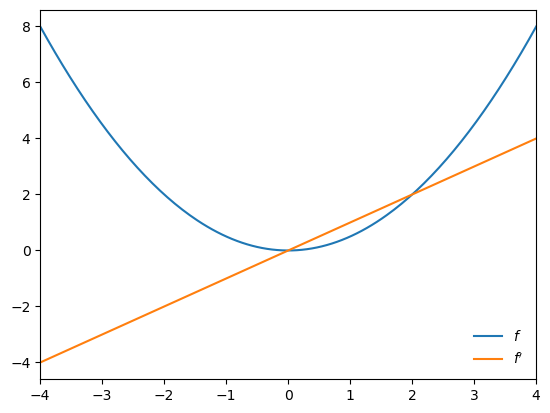

In [16]:
fig, ax = plt.subplots()

xgrid = jnp.linspace(-4, 4, 200)

ax.plot(xgrid, f(xgrid), label='$f$')
ax.plot(xgrid, [df(x) for x in xgrid], label="$f'$")

ax.legend(frameon=False)
ax.set_xmargin(0)
plt.show()

### 3.7. Writing Vectorized Code

Writing fast JAX code requires shifting repetitive tasks from loops to array processing operations, so that the JAX compiler can easily understand the whole operation and generate more efficient machine code. This procedure is called **vectorization** or **array programming**, and will be familiar to anyone who has used NumPy or MATLAB.

In most ways, vectorization is the same in JAX as it is in NumPy. But there are also some differences, which we highlight here. As a running example, consider the function $$f(x, y) = \frac{\cos(x^2 + y^2)}{1 + x^2 + y^2}$$

Suppose that we want to evaluate this function on a square grid of $x$ and $y$ points and then plot it. To clarify, here is the slow `for` loop version.

In [53]:
@jax.jit
def f(x, y):
    return jnp.cos(x**2 + y**2) / (1 + x**2 + y**2)

n = 80
x = jnp.linspace(-2, 2, n)
y = x

z = np.empty((n, n))

In [54]:
%%time
for i in range(n):
    for j in range(n):
        z[i, j] = f(x[i], y[j])

CPU times: total: 1.84 s
Wall time: 4.31 s


Even for this small grid, the run time is extremely slow. Then how can we do the same operation in vectorized form? If you are new to vectorization, you might guess that we can simply write

In [19]:
z_bad = f(x, y)

But this gives us the wrong result because JAX doesn't understand the nested for loop.

In [20]:
z_bad.shape

(80,)

Here is what we actually wanted:

In [21]:
z.shape

(80, 80)

The first adjustment we can try is to simply nest for-loop in function.

In [47]:
@jax.jit
def f_loop(x, y):
    nx = x.shape[0]
    ny = y.shape[0]
    z = jnp.empty((nx, ny))
    for xi in range(nx):
        for yi in range(ny):
            z = z.at[xi, yi].set(jnp.cos(x[xi]**2 + y[yi]**2) / (1 + x[xi]**2 + y[yi]**2))
    return z

In [48]:
n = 80
x = jnp.linspace(-2, 2, n)
y = x

In [49]:
%%time
z_loop = f_loop(x, y)

CPU times: total: 1min 20s
Wall time: 2min 25s


We run it again to get rid of compile time.

In [50]:
%%time
z_loop = f_loop(x, y)

CPU times: total: 0 ns
Wall time: 6.12 ms


In [55]:
jnp.allclose(z_loop, z)

Array(True, dtype=bool)

After compilation there is a significant decrease in execution time. It also gives a correct output. While this method is still inefficient in general (compilation time increases as the size of an input array gets bigger), it may be useful when conducting high-dimensional complex elementwise operations (especially when you're too tired to consider effeciency of the code!).

Next, to get the right shape and the correct nested for loop calculation, we can use a `meshgrid` operation designed for this purpose:

In [99]:
x_mesh, y_mesh = jnp.meshgrid(x, y)

Now we get what we want and the execution time is very fast.

In [100]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: total: 31.2 ms
Wall time: 41 ms


Let's run again to eliminate compile time.

In [101]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: total: 0 ns
Wall time: 997 μs


Let's confirm that we got the right answer.

In [104]:
# Check if two arrays are element-wise approximately equal within a tolerance.
jnp.allclose(z_mesh, z)

Array(True, dtype=bool)

Now we can set up a serious grid and run the same calculation (on the larger grid) in a short amount of time.

In [105]:
n = 6000
x = jnp.linspace(-2, 2, n)
y = x
x_mesh, y_mesh = jnp.meshgrid(x, y)

In [106]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: total: 484 ms
Wall time: 391 ms


Let's run again to get rid of compile time.

In [109]:
%%time
z_mesh = f(x_mesh, y_mesh).block_until_ready()

CPU times: total: 172 ms
Wall time: 245 ms


But there is one problem here: the mesh grids use a lot of memory.

In [110]:
x_mesh.nbytes + y_mesh.nbytes

576000000

By comparison, the flat array `x` is just

In [112]:
x.nbytes # and `y` is jsut a pointer to x

48000

This extra memory usage can be a big problem in actual research calculations. So let's try a different approach using `jax.vmap`. First we vectorize `f` in `y`.

In [113]:
f_vec_y = jax.vmap(f, in_axes=(None, 0))

In the line above, `(None, 0)` indicateds that we are vectorizing in the second argument, which is `y`. Next, we vectorize in the first argument, which is `x`.

In [114]:
f_vec = jax.vmap(f_vec_y, in_axes=(0, None))

With this construction, we can now call the function `f` on flat (low memory) arrays.

In [115]:
%%time
z_vmap = f_vec(x, y).block_until_ready()

CPU times: total: 906 ms
Wall time: 829 ms


We run it again to eliminate compile time.

In [116]:
%%time
z_vmap = f_vec(x, y).block_until_ready()

CPU times: total: 422 ms
Wall time: 359 ms


The execution time is essentially the same as the mesh operation but we are using much less memory. Also we produce the correct answer:

In [117]:
jnp.allclose(z_vmap, z_mesh)

Array(True, dtype=bool)

## 4. Parallel Computing

In this section we cover **parallel computing** in Python. This means you will be able to run your code simultaneously on multiple cores on your CPU processors or increase the speed by taking advantage of the wasted CPU cycles while your program is waiting for external resources (e.g., downloading files, API calls, etc.). The fundamental idea of parallel computing is rooted in doing multiple tasks at the same time to reduce the running time of your program. The following figure illustrates the simple idea of doing parallel computing versus serial computing that we use so far.

For example, if you have one million data files and need to apply the same operations to each one of them, you can do this one file at each time, or you can do it by multiple files at the same time; or if you are downloading one million websites, you can take advantage of downloading 10 at a time to reduce the total time of downloading. Therefore, learning the basics of parallel computing will help you design code that is more efficient.

Most of the modern computers are using the multi-core design, which means on a single computing component, there are multiple independent processing units, the so called cores, that are available to do different tasks. 

In Python, there are two basic approaches to conduct parallel computing, that is using the `multiprocessing` or `threading` library. Let's first take a look of the differences of process and thread.

### 4.1. Process and Thread

A **process** is an instance of a program (such as Python interpreter, Jupyter notebook, etc.). A process is created by the operating system to run program, and each process has its own memory block. A **thread** is a sub-process that reside within the process. Each process can have multiple threads, that these threads will share the same memory block within the process. Thus, for multiple threads in a process, due to the shared memory space, the variables or objects are all shared. If you change one variable in one thread, it will change for all the other threads. But things are different in different processes, changing one variable in one process will not change the one in other processes. Process and thread both have advantages or disadvantages, and can be used in different tasks to maximize the benefits.

### 4.2. Python's GIL Problem

Python has something called Global Interpreter Lock (GIL) which allow only one native thread to run at a time, preventing multiple threads from running simultaneously. This is because Python was designed before the multi-core processor on the personal computers. Even though there are workarounds in Python to do multithreading programming, we will only cover the multiprocessing library in the next subsection, which we will use most of the time for taking advantage of multi-core parallel computing.

### 4.3. Disadvantages of Parallel Computing

Of course, there are disadvantages of using parallel computing. Such as, more complicated code, overheads when spawn new processes and maintain them. Thus, if your task is small, using parallel computing will take longer time, since it takes time for the system to initialize new process and maintain them.

### 4.4. Multiprocessing

The multiprocessing library is the Python's standard library to support parallel computing using processes. It has many different features, if you wan to know all the details, you can check the official documentation. Here we will introduce the basics to get you start with parallel computing. Let's start by importing the library.

In [43]:
import multiprocessing as mp

Let's first print out the total number of CPUs that on my machine that can be used for parallel computing.

In [44]:
print(f'Number of CPUs: {mp.cpu_count()}')

Number of CPUs: 4


Let's use an example to show you how to use multiple cores in one machine to reduce the execution time. We will generate 10,000,000 random numbers between 0 and 10 one-by-one, square them, and store the results in a list. Note that to run `multiprocessing` properly, we need to write the function into a separate `.py` file and import it.

In [40]:
%%writefile ./supp/random_square.py

import numpy as np

def random_square(seed):
    np.random.seed(seed)
    random_num = np.random.randint(0, 10)
    return random_num**2

Writing ./supp/random_square.py


The code below is the serial version of the example (what we have done so far).

In [41]:
from supp.random_square import random_square

In [47]:
%%time
results = []
for i in range(10_000_000):
    results.append(random_square(i))

CPU times: total: 36.7 s
Wall time: 1min 30s


Next we see the parallel version of the example.

In [48]:
%%time
n_cpu = mp.cpu_count()
pool = mp.Pool(processes=n_cpu)
results = [pool.map(random_square, range(10_000_000))]
pool.close()

CPU times: total: 2.64 s
Wall time: 1min


The simplest way to do parallel computing using the multiprocessing is to sue the `Pool` class. There are four common methods in the class that we may use often, which are `apply`, `map`, `apply_async` and `map_async`. Have a look at the documentation for the differences. Here we only uses `map` method above to paralled the above example. The `map(func, iterable)` method takes in two arguments, and apply the function `func` to each element in the `iterable`, and then collect the results.